In [9]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from prophet import Prophet
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
# Connexion
server = 'DESKTOP-5VN40EI\\SS'
database = 'DW_finale'
conn_str = f'mssql+pyodbc://@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'
engine = create_engine(conn_str)


# Requête enrichie avec Catégorie
query = """

SELECT 
    fs.Prix_Unitaire_TND_1, 
    fs.Quantite,
    d.Year, 
    d.Month
  
FROM Fact_Sales fs
JOIN Dim_Date d ON fs.Date_FK = d.Date_PK
JOIN Dim_Product p ON fs.Product_PK = p.Product_PK

"""


df = pd.read_sql(query, engine)



In [11]:
# Regrouper par mois et catégorie
df_grouped = df.groupby(['Year', 'Month']).agg({
    'Prix_Unitaire_TND_1': 'mean',
    'Quantite': 'sum'
}).reset_index()


In [13]:
# Standardisation
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_grouped[['Prix_Unitaire_TND_1', 'Quantite']])


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

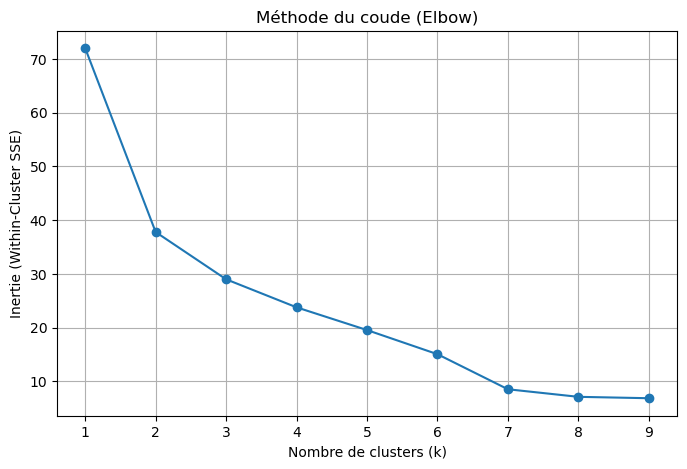

In [15]:
# 📈 Méthode du coude
inertias = []
K_range = range(1, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title("Méthode du coude (Elbow)")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie (Within-Cluster SSE)")
plt.grid(True)
plt.show()


C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


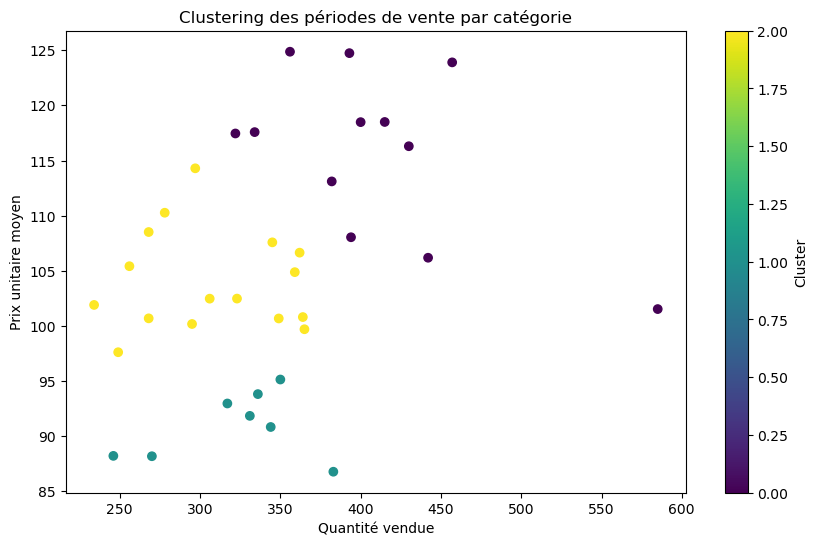

In [39]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df_grouped['Cluster'] = kmeans.fit_predict(df_scaled)

# 🎨 Affichage des clusters
plt.figure(figsize=(10, 6))
plt.scatter(
    df_grouped['Quantite'],
    df_grouped['Prix_Unitaire_TND_1'],
    c=df_grouped['Cluster'],
    cmap='viridis'
)
plt.title("Clustering des périodes de vente par catégorie")
plt.xlabel("Quantité vendue")
plt.ylabel("Prix unitaire moyen")
plt.colorbar(label="Cluster")
plt.show()

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Clustering avec KMeans
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df_scaled)

# Ajout des labels au dataframe
df_grouped['KMeans_Cluster'] = labels

# Évaluation : Silhouette Score
score = silhouette_score(df_scaled, labels)
print(f"✅ Silhouette Score pour K-Means (k={k}) : {score:.4f}")


✅ Silhouette Score pour K-Means (k=3) : 0.3255


C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


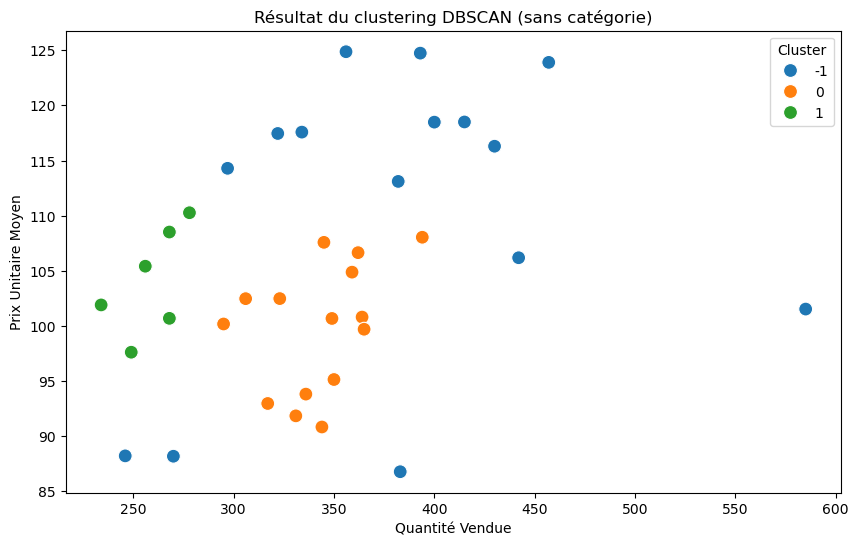

Silhouette Score pour DBSCAN : 0.2165


In [113]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Étape 1 : Sélection des colonnes numériques (exclure la catégorie)
features = ['Quantite', 'Prix_Unitaire_TND_1']  # Ajoute d'autres colonnes si dispo
df_cluster = df_grouped[features].copy()

# Étape 2 : Standardiser les données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Étape 3 : Appliquer DBSCAN
dbscan = DBSCAN(eps=0.6, min_samples=5)  # eps et min_samples à ajuster
df_grouped['DBSCAN_Cluster'] = dbscan.fit_predict(df_scaled)

# Étape 4 : Visualiser les clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_cluster['Quantite'],
    y=df_cluster['Prix_Unitaire_TND_1'],
    hue=df_grouped['DBSCAN_Cluster'],
    palette='tab10',
    s=100
)
plt.title("Résultat du clustering DBSCAN (sans catégorie)")
plt.xlabel("Quantité Vendue")
plt.ylabel("Prix Unitaire Moyen")
plt.legend(title='Cluster')
plt.show()

# Étape 5 : Évaluer avec le Silhouette Score (si plus d’un cluster)
labels = df_grouped['DBSCAN_Cluster']
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

if n_clusters > 1:
    silhouette = silhouette_score(df_scaled, labels)
    print(f"Silhouette Score pour DBSCAN : {silhouette:.4f}")
else:
    print("Silhouette Score non calculé : un seul cluster détecté ou que des outliers.")


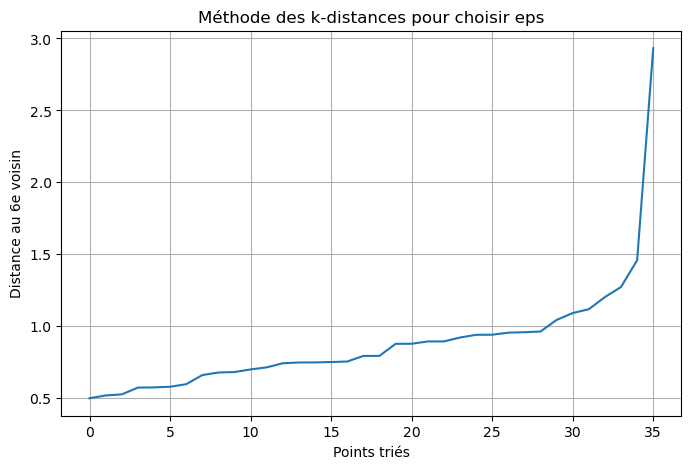

In [115]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Calculer les distances au 6e voisin le plus proche (min_samples=6)
neighbors = NearestNeighbors(n_neighbors=6)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)
distances = np.sort(distances[:, 5], axis=0)

# Tracer la courbe des k-distances
plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.title("Méthode des k-distances pour choisir eps")
plt.xlabel("Points triés")
plt.ylabel("Distance au 6e voisin")
plt.grid(True)
plt.show()


In [121]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=3, random_state=42)
labels = spectral.fit_predict(df_scaled)
score = silhouette_score(df_scaled, labels)
print(f"Silhouette Score pour Spectral Clustering : {score:.4f}")

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score pour Spectral Clustering : 0.3223


C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

Random State = 0, Silhouette Score = 0.4230
Random State = 35, Silhouette Score = 0.4230
Random State = 42, Silhouette Score = 0.4230
Random State = 100, Silhouette Score = 0.4230
Random State = 123, Silhouette Score = 0.4230

Meilleur Random State = 0, Meilleur Silhouette Score = 0.4230


C:\Users\pc\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


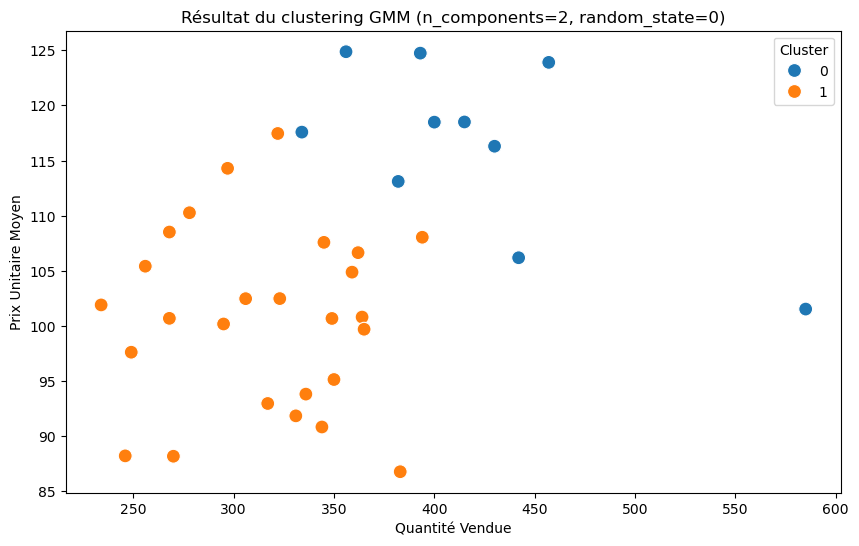

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Sélection des colonnes (déjà fait dans votre cas)
features = ['Quantite', 'Prix_Unitaire_TND_1']
df_cluster = df_grouped[features].copy()

# Standardisation des données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Tester différentes valeurs de random_state
random_states = [0, 35, 42, 100, 123]  # Quelques valeurs arbitraires à tester
best_score = -1
best_random_state = None
best_labels = None

for rs in random_states:
    # Appliquer GMM avec le random_state actuel
    gmm = GaussianMixture(n_components=2, random_state=rs)
    labels = gmm.fit_predict(df_scaled)
    
    # Calculer le score de silhouette
    score = silhouette_score(df_scaled, labels)
    print(f"Random State = {rs}, Silhouette Score = {score:.4f}")
    
    # Garder le meilleur résultat
    if score > best_score:
        best_score = score
        best_random_state = rs
        best_labels = labels

# Afficher le meilleur résultat
print(f"\nMeilleur Random State = {best_random_state}, Meilleur Silhouette Score = {best_score:.4f}")

# Ajouter les labels au DataFrame pour visualisation
df_grouped['GMM_Cluster'] = best_labels

# Visualiser les clusters avec le meilleur random_state
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df_cluster['Quantite'],
    y=df_cluster['Prix_Unitaire_TND_1'],
    hue=df_grouped['GMM_Cluster'],
    palette='tab10',
    s=100
)
plt.title(f"Résultat du clustering GMM (n_components=2, random_state={best_random_state})")
plt.xlabel("Quantité Vendue")
plt.ylabel("Prix Unitaire Moyen")
plt.legend(title='Cluster')
plt.show()